> Artificial Intelligence II - Homework 4/Notebook 2 <br>
> Student: Eirini Kolimatsi <br>
> AM: 7115112200015

# Setup

In [ ]:
# google drive connection
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gc
import re
import string
import time
import traceback
from ast import literal_eval
from itertools import product
from tqdm import tqdm
tqdm.pandas(position=0, leave=True)

In [ ]:
# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer

# pytorch imports
import torchtext
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split, RandomSampler, SequentialSampler
import torch
import torch.nn as nn
import torch.nn.functional as F

# huggingface imports
!pip install transformers

from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
import logging
# bert config
logging.basicConfig(level=logging.INFO)
bert_model = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install wikidata
from wikidata.client import Client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install unidecode
from unidecode import unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# gpu config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on: ", device)

torch.manual_seed(0)
torch.cuda.manual_seed(0)

gc.collect()
torch.cuda.empty_cache()

Running on:  cuda


# Dataset Preparation

In [ ]:
url_test = 'https://raw.githubusercontent.com/askplatypus/wikidata-simplequestions/master/annotated_wd_data_test_answerable.txt'
url_train = 'https://raw.githubusercontent.com/askplatypus/wikidata-simplequestions/master/annotated_wd_data_train_answerable.txt'
url_valid = 'https://raw.githubusercontent.com/askplatypus/wikidata-simplequestions/master/annotated_wd_data_valid_answerable.txt'

# load data from github
df_test = pd.read_csv(url_test, header=None, delimiter='\t')
df_train = pd.read_csv(url_train, header=None, delimiter='\t')
df_valid = pd.read_csv(url_valid, header=None, delimiter='\t')

df_test.columns = ['entity_id','relation_id','answer_id','question']
df_train.columns = ['entity_id','relation_id','answer_id','question']
df_valid.columns = ['entity_id','relation_id','answer_id','question']

In [ ]:
df_train.head()

,entity_id,relation_id,answer_id,question
0,Q12439,R19,Q6106580,who is a musician born in detroit
1,Q6817891,P364,Q1568,what is the language in which mera shikar was ...
2,Q1297,R276,Q2888523,Whats the name of a battle that happened in ch...
3,Q193592,R413,Q5822614,what player plays the position midfielder?
4,Q6849115,P413,Q336286,what is the position that mike twellman plays


In [ ]:
# get all unique ids from all datasets
all_ids = list(np.unique(df_train[['entity_id', 'relation_id', 'answer_id']].values)) + list(np.unique(df_valid[['entity_id', 'relation_id', 'answer_id']].values)) + list(np.unique(df_test[['entity_id', 'relation_id', 'answer_id']].values))
all_ids = list(set(all_ids))

In [ ]:
len(all_ids)

35122

In [ ]:
# get the labels from the wikidata api
batch_size = 1500
batches = [(i, i+batch_size-1) for i in range(0,len(all_ids),batch_size)]
batches.reverse()
failed_ids = []
labels={}

for idx, batch in enumerate(batches):
  print(f'batch {idx+1}/{len(batches)}')
  client = Client()
  for i, wikidata_id in enumerate(all_ids[batch[0]:batch[1]]):
    if i%500==0:
      print(f'{i}/{len(all_ids[batch[0]:batch[1]])}')
    try:
      entity = client.get(wikidata_id)
      labels[wikidata_id] = entity.label
    except:
      print(f'failed for {wikidata_id}')
      # traceback.format_exc()
      client = Client()
      failed_ids.append(wikidata_id)
      time.sleep(10)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
batch 1/24
0/622
failed for R376
500/622
failed for R175
batch 2/24
0/1499
failed for R1303
failed for Q1112954
500/1499
1000/1499
failed for Q15039830
batch 3/24
0/1499
failed for Q4765159
failed for R144
failed for R177
failed for Q4899445
500/1499
failed for Q16240137
failed for Q7418458
1000/1499
batch 4/24
0/1499
failed for R421
failed for R106
500/1499
1000/1499
failed for R162
batch 5/24
0/1499
500/1499
failed for Q6209350
1000/1499
failed for R138
batch 6/24
0/1499
failed for R413
failed for R172
failed for R40
500/1499
failed for R170
1000/1499
batch 7/24
0/1499
failed for Q6555000
500/1499
1000/1499
batch 8/24
0/1499
500/1499
1000/1499
batch 9/24
0/1499
failed for Q16969398
failed for R58
failed for R17
500/1499
1000/1499
batch 10/24
0/1499
failed for R1431
failed for R136
500/1499
failed for R50
1000/1499
batch 11/24
0/1499
500/1499
failed for R115
failed for R179
failed for R6

In [ ]:
len(failed_ids)

67

In [ ]:
# retry for the ids that failed in the previous loop
client = Client()
for l in failed_ids:
  try:
    entity = client.get(l)
    labels[l] = entity.label
    print(f'success for {l}')
  except:
    print(f'{l}---')

R376---
R175---
R1303---
Q1112954---
Q15039830---
Q4765159---
R144---
R177---
Q4899445---
Q16240137---
Q7418458---
R421---
R106---
R162---
Q6209350---
R138---
R413---
R172---
R40---
R170---
Q6555000---
Q16969398---
R58---
R17---
R1431---
R136---
R50---
R115---
R179---
R641---
R404---
R276---
Q5159450---
R509---
Q6986912---
R1040---
R119---
Q4955488---
R149---
R131---
R59---
Q4896923---
R289---
R676---
R287---
R171---
R31---
R264---
Q5074888---
Q4996625---
R344---
R21---
Q8035651---
R272---
R86---
Q6316154---
R112---
R19---
R176---
R279---
R1142---
R161---
R607---
R123---
R178---
R105---
R57---


In [ ]:
mapping = pd.DataFrame.from_dict(labels, orient='index')
mapping.to_csv('/content/drive/My Drive/Colab Notebooks/data/assignment4_q2_mapping.csv')

In [ ]:
# to be used after the 1st run
# mapping = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/assignment4_q2_mapping.csv', index_col=0)
# all_labels = mapping.en

/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (5,6,8,12,17,20,21,24,25,30,36,38,39,40,41,45,47,51,56,58,60,61,75,76,78,107,108,113,118,128,129,130,134,141,142,145,146,147,155,159,170,172,173,175,189,194,196,197,198,207,212,214,216,217,218,219,222,223,230,236,237,242,246,247,250,254,257,265,267,273,282,289,290,291,294,295,302,308,313,315,329,331,333,335,336,344,345,346,348,349,358,360,361,366,367,369,370,372,373,375,377,392,396,400,405,415,421,425,426,431,434,435,439,447,451,462) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
mapping.head()

,aa,ab,ace,ady,ady-cyrl,aeb,aeb-arab,aeb-latn,af,ak,...,zh,zh-cn,zh-hans,zh-hant,zh-hk,zh-mo,zh-my,zh-sg,zh-tw,zu
Q981960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q765579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,跳躍青春,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q11330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,原田眞人,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q769110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q15998268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
all_labels = pd.DataFrame.from_dict(labels, orient='index').en

In [ ]:
all_labels.head()

Q981960      Ivan Kireyevsky
Q765579             Jump In!
Q11330         Masato Harada
Q769110            Andy Todd
Q15998268        Miguel Vera
Name: en, dtype: object

In [ ]:
df_test['entity_id'].map(all_labels)

0           Roger Marquis
1              Yves Klein
2            Carlos Gómez
3       Engelbert Zaschka
4           Pee Wee Reese
              ...        
5617            Barcelona
5618             Jun Lana
5619      Gunnar Johansen
5620          2974 Holden
5621      Lucille Clifton
Name: entity_id, Length: 5622, dtype: object

In [ ]:
# get the labels in the datasets
def id_2_label(df, mapping=all_labels):
  df['entity_label'] = df['entity_id'].map(mapping) 
  df = df.loc[~df['entity_label'].isna()]
  df['relation_label'] = df['relation_id'].map(mapping) 
  df = df.loc[~df['relation_label'].isna()]
  df['id'] = range(1, 1+len(df))
  df = df[['id', 'entity_id', 'entity_label', 'relation_id', 'relation_label', 'question']]

  return df

train_data = id_2_label(df_train)
test_data = id_2_label(df_test)
val_data = id_2_label(df_valid)

<ipython-input-85-71af35aee6a6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['relation_label'] = df['relation_id'].map(mapping)


In [ ]:
train_data.head()

,id,entity_id,entity_label,relation_id,relation_label,question
1,1,Q6817891,Mera Shikar,P364,original language of film or TV show,what is the language in which mera shikar was ...
4,2,Q6849115,Mike Twellman,P413,position played on team / speciality,what is the position that mike twellman plays
6,3,Q7273,Ellen Swallow Richards,P27,country of citizenship,what is ellen swallow richards's nationality?
7,4,Q247643,Elementary,P364,original language of film or TV show,What language is the show elementary broadcast...
8,5,Q6135854,James Hendry,P21,sex or gender,what is the gender of james hendry?


In [ ]:
# get the spans for each question
def tokenize_questions(row):
    q = row['question'].translate(str.maketrans('', '', string.punctuation)).lower().split()
    e = unidecode(row['entity_label'].translate(str.maketrans('', '', string.punctuation))).lower().split()
    return list(1 if unidecode(t) in e else 0 for t in q)

train_data['match_span'] = train_data.progress_apply(tokenize_questions, axis=1)
test_data['match_span'] = test_data.progress_apply(tokenize_questions, axis=1)
val_data['match_span'] = val_data.progress_apply(tokenize_questions, axis=1)

100%|██████████| 2202/2202 [00:00<00:00, 22084.79it/s]


In [ ]:
train_data.head()

,id,entity_id,entity_label,relation_id,relation_label,question,match_span
1,1,Q6817891,Mera Shikar,P364,original language of film or TV show,what is the language in which mera shikar was ...,"[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]"
4,2,Q6849115,Mike Twellman,P413,position played on team / speciality,what is the position that mike twellman plays,"[0, 0, 0, 0, 0, 1, 1, 0]"
6,3,Q7273,Ellen Swallow Richards,P27,country of citizenship,what is ellen swallow richards's nationality?,"[0, 0, 1, 1, 0, 0]"
7,4,Q247643,Elementary,P364,original language of film or TV show,What language is the show elementary broadcast...,"[0, 0, 0, 0, 0, 1, 0, 0]"
8,5,Q6135854,James Hendry,P21,sex or gender,what is the gender of james hendry?,"[0, 0, 0, 0, 0, 1, 1]"


In [ ]:
# save data for future use
train_data.to_csv('/content/drive/My Drive/Colab Notebooks/data/assignment4_q2_train_data.csv')
test_data.to_csv('/content/drive/My Drive/Colab Notebooks/data/assignment4_q2_test_data.csv')
val_data.to_csv('/content/drive/My Drive/Colab Notebooks/data/assignment4_q2_val_data.csv')

# Supporting Datasets

In [ ]:
# load data (to avoid rerunning all)
train_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/assignment4_q2_train_data.csv')
test_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/assignment4_q2_test_data.csv')
val_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/assignment4_q2_val_data.csv')

train_data['match_span'] = train_data['match_span'].apply(literal_eval)
test_data['match_span'] = test_data['match_span'].apply(literal_eval)
val_data['match_span'] = val_data['match_span'].apply(literal_eval)

In [ ]:
# relation ids vocabulary
def relation_vocab(df):
  vocab = df['relation_id'].unique()
  vocab = pd.DataFrame(vocab).reset_index()
  vocab.columns = ['id', 'relation_id']
  return vocab

rel_vocab_train = relation_vocab(train_data)
rel_vocab_test = relation_vocab(test_data)
rel_vocab_valid = relation_vocab(val_data)

In [ ]:
rel_vocab_train.head()

,id,relation_id
0,0,P364
1,1,P413
2,2,P27
3,3,P21
4,4,P196


In [ ]:
# checking if there are relations in test or valid that are not in train
m = rel_vocab_train.merge(rel_vocab_test, on='relation_id', how='outer').merge(rel_vocab_valid, on='relation_id', how='outer')
m.loc[m['id_x'].isna()]

,id_x,relation_id,id_y,id


In [ ]:
# entity id/label mapping
def entity_2_label(df): 
  return df.loc[:,['entity_label', 'entity_id']].drop_duplicates().reset_index(drop=True)

ent2lab_train = entity_2_label(train_data)
ent2lab_test = entity_2_label(test_data)
ent2lab_valid = entity_2_label(val_data)

In [ ]:
ent2lab_train.head()

,entity_label,entity_id
0,Mera Shikar,Q6817891
1,Mike Twellman,Q6849115
2,Ellen Swallow Richards,Q7273
3,Elementary,Q247643
4,James Hendry,Q6135854


In [ ]:
# max question length
max(train_data.question.apply(lambda x: len(x.split())))

21

# Datasets to Tensors & BERT Encoding

In [ ]:
# checking if all spans are correctly created
train_data['sm'] = train_data['match_span'].apply(sum)
train_data.loc[train_data['sm']==0]

,Unnamed: 0,id,entity_id,entity_label,relation_id,relation_label,question,match_span,sm
11,19,12,Q101625,Marrakesh,P421,located in time zone,what time zone is marrakech in?,"[0, 0, 0, 0, 0, 0]",0
105,148,106,Q7049742,Noon at Ngayon: Pagsasamang Kay Ganda,P495,country of origin,WHich nation filmed then and now,"[0, 0, 0, 0, 0, 0]",0
286,385,287,Q3287722,Marc-Éric Gueï,P27,country of citizenship,what coast does was nominated for Classical Al...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0
350,466,351,Q4930404,Blueprint,P404,game mode,what player mode is blue print played on?,"[0, 0, 0, 0, 0, 0, 0, 0]",0
505,676,506,Q1920221,Menaḥem ben Shelomoh Meʾiri,P21,sex or gender,is menachem meiri male or female,"[0, 0, 0, 0, 0, 0]",0
...,...,...,...,...,...,...,...,...,...
14489,19016,14490,Q16228552,Henry Stein,P413,position played on team / speciality,What is the baseball position played by harry ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0
14636,19212,14637,Q7294016,Rafe,P27,country of citizenship,What was raphael specht's nationality?,"[0, 0, 0, 0, 0]",0
14695,19284,14696,Q11058167,Zid,P495,country of origin,What country is Zin filmed in?,"[0, 0, 0, 0, 0, 0]",0
14749,19355,14750,Q1563359,Nervia,P59,constellation,what constellation is hd 49674 apart of,"[0, 0, 0, 0, 0, 0, 0]",0


In [ ]:
train_data.drop(['sm'],axis=1)

,Unnamed: 0,id,entity_id,entity_label,relation_id,relation_label,question,match_span
0,1,1,Q6817891,Mera Shikar,P364,original language of film or TV show,what is the language in which mera shikar was ...,"[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]"
1,4,2,Q6849115,Mike Twellman,P413,position played on team / speciality,what is the position that mike twellman plays,"[0, 0, 0, 0, 0, 1, 1, 0]"
2,6,3,Q7273,Ellen Swallow Richards,P27,country of citizenship,what is ellen swallow richards's nationality?,"[0, 0, 1, 1, 0, 0]"
3,7,4,Q247643,Elementary,P364,original language of film or TV show,What language is the show elementary broadcast...,"[0, 0, 0, 0, 0, 1, 0, 0]"
4,8,5,Q6135854,James Hendry,P21,sex or gender,what is the gender of james hendry?,"[0, 0, 0, 0, 0, 1, 1]"
...,...,...,...,...,...,...,...,...
14833,19474,14834,Q595352,"""Heroes""",P136,genre,what kind of music is on the album heroes,"[0, 0, 0, 0, 0, 0, 0, 0, 1]"
14834,19475,14835,Q6322943,K.Flay,P19,place of birth,Where was k.flay born?,"[0, 0, 1, 0]"
14835,19476,14836,Q223960,mountain tapir,P171,parent taxon,what classification does mountain tapir come ...,"[0, 0, 0, 1, 1, 0, 0]"
14836,19479,14837,Q16093542,Anthony Bailey,P27,country of citizenship,What is the nationality of anthony bailey,"[0, 0, 0, 0, 0, 1, 1]"


In [ ]:
BATCH_SIZE = 16

# BERT toeknization/encoding
def apply_tokenization(df, vocab=rel_vocab_train, sampler=RandomSampler, shuffle=True):
  # drop rows that span could not be created
  df['sum_span'] = df['match_span'].apply(sum)
  df = df.loc[df['sum_span']!=0]

  # bert encoding
  MAX_SEQ_LEN = max(df.question.apply(lambda x: len(x.split())))
  token_id = []
  attention_masks = []
  size = 0
  for x in df['question'].to_list():
    encoded_x = tokenizer.encode_plus(
                        x,
                        add_special_tokens = True,
                        truncation=True,
                        max_length = MAX_SEQ_LEN+2,
                        padding = 'max_length',
                        return_attention_mask = True,
                        return_tensors = 'pt')
    
    
    token_id.append(encoded_x['input_ids']) 
    attention_masks.append(encoded_x['attention_mask'])

  # start/end position for spans
  start_pos = df['match_span'].apply(lambda x: x.index(1)).to_list()
  end_pos = df['match_span'].apply(lambda x: len(x) - x[::-1].index(1)-1).to_list()

  token_id = torch.cat(token_id, dim = 0)
  attention_masks = torch.cat(attention_masks, dim = 0)
  labels = torch.tensor(df['relation_id'].map(vocab.set_index('relation_id').to_dict()['id']).to_list())
  span_start = torch.tensor(start_pos)
  span_end = torch.tensor(end_pos)

  # create pytorch dataset
  dataset = TensorDataset(token_id, attention_masks, labels, span_start, span_end)
  
  # create pytorch dataloader
  dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle=shuffle)
  return dataset, dataloader

In [ ]:
# create dataloaders for train, val, test
train_dataset, train_dataloader = apply_tokenization(train_data)
test_dataset, test_dataloader = apply_tokenization(test_data, sampler=SequentialSampler, shuffle=False)
val_dataset, val_dataloader = apply_tokenization(val_data, sampler=SequentialSampler, shuffle=False)

# Relation Classifier

In [ ]:
# Relation classification model
class RelationClassifier(nn.Module):
    def __init__(self, vocab=rel_vocab_train, hidden_size = 50, freeze_bert=False):
        super(RelationClassifier, self).__init__()
        D_in, H, D_out = 768, hidden_size, len(rel_vocab_train)

        # BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Feed Forward Classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        # Pass input from BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state for CLS
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Pass from the classifier to get the logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [ ]:
# Plot learning curves
def plot_learning(train_loss, val_loss, epoch_tr_acc, epoch_vl_acc, num_epochs, save_plots=False):
  X_values = np.arange(num_epochs)

  # Loss vs Epochs
  fig = plt.figure(figsize=(11,5))
  ax1 = fig.add_subplot(121)
  ax1.plot(X_values, train_loss, label= 'train')
  ax1.plot(X_values, val_loss, label= 'validation')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  plt.title('Training & Validation Loss')
  ax1.legend()

  # Accuracy vs Epochs
  ax2 = fig.add_subplot(122)
  ax2.plot(X_values, epoch_tr_acc, label= 'train')
  ax2.plot(X_values, epoch_vl_acc, label= 'validation')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  plt.title('Training & Validation Accuracy')
  ax2.legend()

  if save_plots:
    plt.savefig(save_plots+'_loss_acc.png')

  plt.show()

In [ ]:
# train the model
def train(model, optimizer, scheduler, criterion, train_dataloader):
      tr_loss, tr_accuracy = [], []
      
      model.train()

      for step, batch in enumerate(train_dataloader):
          input_ids, attn_mask, labels, _, _ = tuple(t.to(device) for t in batch)

          # Zero out any previously calculated gradients
          model.zero_grad()

          # Get logits & compute loss
          logits = model(input_ids, attn_mask)
          loss = criterion(logits, labels)
          tr_loss.append(loss.item())

          loss.backward()

          # Gradient Clipping
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          optimizer.step()
          scheduler.step()

          # Predictions
          preds = torch.argmax(logits, dim=1).flatten()

          # Accuracy rate
          accuracy = (preds == labels).cpu().numpy().mean() * 100
          tr_accuracy.append(accuracy)
        
      avg_train_loss = np.mean(tr_loss)
      avg_accuracy = np.mean(tr_accuracy)

      return avg_train_loss, avg_accuracy

In [ ]:
# validate the model
def validate(model, criterion, val_dataloader):
    val_accuracy = []
    val_loss = []

    model.eval()
    
    for batch in val_dataloader:
        input_ids, attn_mask, labels, _, _ = tuple(t.to(device) for t in batch)

        # Get logits & compute loss
        with torch.no_grad():
            logits = model(input_ids, attn_mask)

        loss = criterion(logits, labels)
        val_loss.append(loss.item())

        # Predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Accuracy rate
        accuracy = (preds == labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [ ]:
# test the model
def test(model, test_dataloader):
    score_accuracy = []
    score_f1 = []
    score_precision = []
    score_recall = []

    model.eval()

    for batch in test_dataloader:
        input_ids, attn_mask, labels, _, _ = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(input_ids, attn_mask)

        # Predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Metrics
        score_f1.append(f1_score(labels.cpu().numpy(),preds.cpu().detach().numpy(),average='micro'))
        score_accuracy.append(accuracy_score(labels.cpu().numpy(),preds.cpu().detach().numpy()))
        score_recall.append(recall_score(labels.cpu().numpy(),preds.cpu().detach().numpy(),average='micro'))
        score_precision.append(precision_score(labels.cpu().numpy(),preds.cpu().detach().numpy(),average='micro'))

    print("F1:        {:.6f}".format(np.mean(score_f1)*100))
    print("Recall:    {:.6f}".format(np.mean(score_recall)*100))
    print("Precision: {:.6f}".format(np.mean(score_precision)*100))
    print("Accuracy:  {:.6f}".format(np.mean(score_accuracy)*100))

In [ ]:
# Run model training
def run(model, optimizer, scheduler, criterion, 
        train_dataloader, val_dataloader, test_dataloader,
        epochs=4):
  val_loss_all, tr_loss_all = [], []
  val_acc_all, tr_acc_all = [], []

  print(f"{'Epoch':^7} | {'Train Loss':^10} | {'Train Acc':^10} | {'Val Loss':^10} | {'Val Acc':^10}")

  for e in range(epochs):
    # Train
    epoch_tr_loss, epoch_tr_acc = train(model, optimizer, scheduler, criterion, train_dataloader)
    # Validate
    epoch_vl_loss, epoch_vl_acc = validate(model, criterion, val_dataloader)

    tr_loss_all.append(epoch_tr_loss)
    tr_acc_all.append(epoch_tr_acc)
    val_loss_all.append(epoch_vl_loss)
    val_acc_all.append(epoch_vl_acc)
    print(f"{e + 1:^7} | {epoch_tr_loss:^10.6f} | {epoch_tr_acc:^10.2f} | {epoch_vl_loss:^10.6f} | {epoch_vl_acc:^10.2f}")

  # Test
  test(model, test_dataloader)

  # Plot learning curves
  plot_learning(tr_loss_all, val_loss_all, tr_acc_all, val_acc_all, epochs)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  | Train Loss | Train Acc  |  Val Loss  |  Val Acc  
   1    |  0.807317  |   87.89    |  0.242858  |   95.79   
   2    |  0.176693  |   97.21    |  0.157005  |   97.18   
   3    |  0.101280  |   98.36    |  0.132651  |   97.87   
F1:        96.530021
Recall:    96.530021
Precision: 96.530021
Accuracy:  96.530021


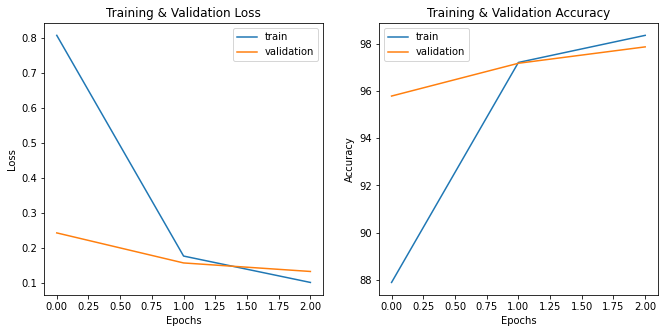

In [ ]:
rel_classifier = RelationClassifier(freeze_bert=False).to(device)

# Optimizer
optimizer = torch.optim.AdamW(rel_classifier.parameters(),
                              lr=5e-5,    # Default learning rate
                              eps=1e-8    # Default epsilon value
                              )
n_epochs = 3
total_steps = len(train_dataloader) * n_epochs

# LR scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0, # Default value
                                            num_training_steps=total_steps)

# Loss Function
criterion = nn.CrossEntropyLoss()

run(rel_classifier, optimizer, scheduler, criterion, 
        train_dataloader, val_dataloader, test_dataloader, epochs = n_epochs)

In [ ]:
# save model
torch.save(rel_classifier,'/content/drive/My Drive/Colab Notebooks/data/assignment4_q2_rel_model.pt')

In [ ]:
# tokenization for prediction 
def apply_tokenization_test(lst):
  MAX_SEQ_LEN = max(len(x.split()) for x in lst)
  token_id = []
  attention_masks = []

  for x in lst:
    encoded_x = tokenizer.encode_plus(
                        x,
                        add_special_tokens = True,
                        truncation=True,
                        max_length = MAX_SEQ_LEN,
                        padding = 'max_length',
                        return_attention_mask = True,
                        return_tensors = 'pt')
    
    
    token_id.append(encoded_x['input_ids']) 
    attention_masks.append(encoded_x['attention_mask'])

  token_id = torch.cat(token_id, dim = 0)
  attention_masks = torch.cat(attention_masks, dim = 0)

  dataset = TensorDataset(token_id, attention_masks)
  
  dataloader = DataLoader(dataset, batch_size = BATCH_SIZE)
  return dataloader

# prediction test
def predict_relation(model, test_dataloader):
    model.eval()

    for batch in test_dataloader:
        input_ids, attn_mask = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(input_ids, attn_mask)

        # Predictions
        preds = torch.argmax(logits, dim=1).flatten()

        return preds

dl = apply_tokenization_test(['where is rihanna from?', 'what is the gender of justin bieber?']) #P27 -> 2, P21 -> 3
predict_relation(rel_classifier, dl)

tensor([2, 3], device='cuda:0')

# Entity Span Detection

In [ ]:
# Entity Span Detection
class SpanDetection(nn.Module):
    def __init__(self, hidden_size = 50, freeze_bert=False):
        super(SpanDetection, self).__init__()
        D_in, H, D_out = 768, hidden_size, 2

        # BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Feed Forward Classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        # Pass input from BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        outputs = outputs[0]

        # Pass from the classifier to get the logits
        logits = self.classifier(outputs)
        # Get the logits for the start and the end of the span heads
        logits_start, logits_end = logits.split(1, dim=-1)
        logits_start = logits_start.squeeze(-1)
        logits_end = logits_end.squeeze(-1)

        return logits_start, logits_end

In [ ]:
# train for entity span detection
def train2(model, optimizer, scheduler, criterion, train_dataloader):
      tr_loss, tr_accuracy = [], []

      model.train()

      for step, batch in enumerate(train_dataloader):
          input_ids, attn_mask, labels, start_pos, end_pos = tuple(t.to(device) for t in batch)

          model.zero_grad()

          # Get logits
          logits_start, logits_end = model(input_ids, attn_mask)

          # start/end position shape transformation
          start_tensor = torch.zeros(logits_start.shape[0],logits_start.shape[1], device=logits_start.device)
          start_tensor[(torch.arange(logits_start.shape[0]), start_pos)] = 1

          end_tensor = torch.zeros(logits_end.shape[0],logits_end.shape[1], device=logits_end.device)
          end_tensor[(torch.arange(logits_end.shape[0]), end_pos)] = 1

          # Compute loss
          loss_start = criterion(logits_start, start_tensor)
          loss_end = criterion(logits_end, end_tensor)
          loss = loss_start + loss_end

          tr_loss.append(loss.item()/2)

          loss.backward()

          # Gradient Clipping
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          optimizer.step()
          scheduler.step()

          # Predictions
          preds_start = torch.argmax(logits_start, dim=1).flatten()
          preds_end = torch.argmax(logits_end, dim=1).flatten()

          # Accuracy rate
          accuracy = torch.torch.logical_and(preds_start == start_pos,preds_end == end_pos).sum()
          tr_accuracy.append(accuracy)
        
      avg_train_loss = np.mean(tr_loss)
      avg_accuracy = (sum(tr_accuracy)/len(train_dataloader.dataset)*100).cpu().numpy()

      return avg_train_loss, avg_accuracy

In [ ]:
# validate for entity span detection
def validate2(model, criterion, val_dataloader):
    val_accuracy = []
    val_loss = []

    model.eval()
    
    for batch in val_dataloader:
        input_ids, attn_mask, labels, start_pos, end_pos = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits_start, logits_end = model(input_ids, attn_mask)
        
        # start/end position shape transformation
        start_tensor = torch.zeros(logits_start.shape[0],logits_start.shape[1], device=logits_start.device)
        start_tensor[(torch.arange(logits_start.shape[0]), start_pos)] = 1

        end_tensor = torch.zeros(logits_end.shape[0],logits_end.shape[1], device=logits_end.device)
        end_tensor[(torch.arange(logits_end.shape[0]), end_pos)] = 1

        # Compute loss
        loss_start = criterion(logits_start, start_tensor)
        loss_end = criterion(logits_end, end_tensor)
        loss = loss_start + loss_end

        val_loss.append(loss.item()/2)

        # Predictions
        preds_start = torch.argmax(logits_start, dim=1).flatten()
        preds_end = torch.argmax(logits_end, dim=1).flatten()

        # Accuracy rate
        accuracy = torch.torch.logical_and(preds_start == start_pos,preds_end == end_pos).sum()
        val_accuracy.append(accuracy)

    val_loss = np.mean(val_loss)
    val_accuracy = (sum(val_accuracy)/len(val_dataloader.dataset)*100).cpu().numpy()

    return val_loss, val_accuracy

In [ ]:
# test for entity span detection
def test2(model, test_dataloader):

    model.eval()

    all_preds_start, all_preds_end, all_true_start, all_true_end = [], [], [], []

    for batch in test_dataloader:
        input_ids, attn_mask, labels, start_pos, end_pos = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits_start, logits_end = model(input_ids, attn_mask)

        # Get the predictions
        preds_start = torch.argmax(logits_start, dim=1).flatten()
        preds_end = torch.argmax(logits_end, dim=1).flatten()

        all_preds_start.append(preds_start)
        all_preds_end.append(preds_end)
        all_true_start.append(start_pos)
        all_true_end.append(end_pos)

    all_preds_start = torch.cat(all_preds_start).cpu().numpy()
    all_preds_end = torch.cat(all_preds_end).cpu().numpy()
    all_true_start = torch.cat(all_true_start).cpu().numpy()
    all_true_end = torch.cat(all_true_end).cpu().numpy()
    
    # get metrics
    compute_metrics(all_preds_start, all_preds_end, all_true_start, all_true_end)

    return all_preds_start, all_preds_end, all_true_start, all_true_end

In [ ]:
# compute metrics for span detection
def compute_metrics(pred_start, pred_end, true_start, true_end):
  # find spans from start & end indexes
  spans_pred, spans_true = [], []
  for ps, pe, ts, te in zip(pred_start, pred_end, true_start, true_end):
    if ps<=pe:
      spans_pred.append(range(ps,pe+1))
    else:
      spans_pred.append(range(0))
    spans_true.append(range(ts,te+1))

  # find common and length of true/predicted spans
  common = [len(np.intersect1d(t,p)) for t,p in zip(spans_true,spans_pred)]
  len_true = [len(t) for t in spans_true]
  len_pred = [len(p) for p in spans_pred]

  # calculate metrics
  span_accuracy = np.logical_and(pred_start == true_start,pred_end == true_end).sum()/len(pred_start)
  precision = np.mean([c/p if p != 0 else 0 for c,p in zip(common, len_pred)])
  recall = np.mean([c/p  if p != 0 else 0 for c,p in zip(common, len_true)])
  f1 = (2 * precision * recall)/(precision+recall)

  metrics = {'accuracy': np.mean(span_accuracy), 'precision': precision, 'recall': recall, 'f1': f1}

  print("F1:        {:.6f}".format(metrics['f1']*100))
  print("Recall:    {:.6f}".format(metrics['recall']*100))
  print("Precision: {:.6f}".format(metrics['precision']*100))
  print("Accuracy:  {:.6f}".format(metrics['accuracy']*100))

In [ ]:
# run training for span detection
def run2(model, optimizer, scheduler, criterion, 
        train_dataloader, val_dataloader, test_dataloader,
        epochs=4):
  val_loss_all, tr_loss_all = [], []
  val_acc_all, tr_acc_all = [], []
  print(f"{'Epoch':^7} | {'Train Loss':^10} | {'Train Acc':^10} | {'Val Loss':^10} | {'Val Acc':^10}")
  for e in range(epochs):
    # Train
    epoch_tr_loss, epoch_tr_acc = train2(model, optimizer, scheduler, criterion, train_dataloader)
    # Validate
    epoch_vl_loss, epoch_vl_acc = validate2(model, criterion, val_dataloader)

    tr_loss_all.append(epoch_tr_loss)
    tr_acc_all.append(epoch_tr_acc)
    val_loss_all.append(epoch_vl_loss)
    val_acc_all.append(epoch_vl_acc)
    print(f"{e + 1:^7} | {epoch_tr_loss:^10.6f} | {epoch_tr_acc:^10.2f} | {epoch_vl_loss:^10.6f} | {epoch_vl_acc:^10.2f}")

  # Test
  test2(model, test_dataloader)
  
  # Plots learning curves
  plot_learning(tr_loss_all, val_loss_all, tr_acc_all, val_acc_all, epochs)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  | Train Loss | Train Acc  |  Val Loss  |  Val Acc  
   1    |  0.396258  |   80.66    |  0.224014  |   90.03   
   2    |  0.181524  |   91.47    |  0.180325  |   93.41   
   3    |  0.115498  |   94.73    |  0.184808  |   93.69   
   4    |  0.075301  |   96.54    |  0.208755  |   93.51   
F1:        98.529569
Recall:    98.779305
Precision: 98.281092
Accuracy:  93.697780


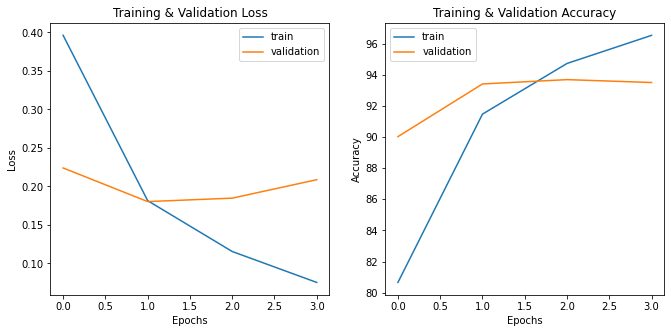

In [ ]:
span_model = SpanDetection(freeze_bert=False).to(device)

# Optimizer
optimizer = torch.optim.AdamW(span_model.parameters(),
                       
                              lr=5e-5,    # Default learning rate
                              eps=1e-8    # Default epsilon value
                              )
n_epochs = 4
total_steps = len(train_dataloader) * n_epochs

# LR scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0, # Default value
                                            num_training_steps=total_steps)

# Loss Function
criterion = nn.CrossEntropyLoss()

run2(span_model, optimizer, scheduler, criterion, 
        train_dataloader, val_dataloader, test_dataloader, epochs = n_epochs)

In [ ]:
# save model
torch.save(span_model,'/content/drive/My Drive/Colab Notebooks/data/assignment4_q2_span_model.pt')

In [ ]:
# predict span 
def predict_span(model, test_dataloader):
    model.eval()

    for batch in test_dataloader:
        input_ids, attn_mask = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits_start, logits_end = model(input_ids, attn_mask)

        # Predictions
        preds_start = torch.argmax(logits_start, dim=1).flatten()
        preds_end = torch.argmax(logits_end, dim=1).flatten()

        return preds_start, preds_end

dl = apply_tokenization_test(['Who is the founder of Facebook?','How old is Barack Obama?'])
predict_span(span_model, dl)

(tensor([5, 3], device='cuda:0'), tensor([5, 4], device='cuda:0'))

Model Paths:
- Relation Model: https://drive.google.com/file/d/1ZVd5vPVzrGlfa8XpOJma1kN7fvYvxFNL/view?usp=share_link
- Span Model: https://drive.google.com/file/d/17j-9RmBqR4NXMb4EnOyBs3IRjSd2xBkc/view?usp=share_link

# Bonus: Question Answering Engine

In [278]:
# unify all ent2label dataframes 
all_ent2lab = pd.concat([ent2lab_test,ent2lab_train,ent2lab_valid]).drop_duplicates().reset_index(drop=True)
all_ent2lab['ent_lower'] = all_ent2lab['entity_label'].str.lower()
all_ent2lab.to_csv('/content/drive/My Drive/Colab Notebooks/data/ent2label.csv')
rel_vocab_train.to_csv('/content/drive/My Drive/Colab Notebooks/data/rel_vocab.csv')

In [261]:
# data & library imports
import requests
import pandas as pd
import numpy as np
import string
import torchtext
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split, RandomSampler, SequentialSampler
import torch
import torch.nn as nn
import torch.nn.functional as F

!pip install transformers
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
import logging
# bert config
logging.basicConfig(level=logging.INFO)
bert_model = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)
!pip install wikidata
from wikidata.client import Client
!pip install unidecode
from unidecode import unidecode

# provide the data paths
all_ent2lab = pd.read_csv('https://drive.google.com/uc?id=1-3zV8RMMqyEuFjcRADWuyq99qu73Hcmr', index_col=0)
rel_vocab_train = pd.read_csv('https://drive.google.com/uc?id=1-21LAyTxSOH6Gt4tVKPhRfsU_Y_eAagL', index_col=0)

# gpu config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on: ", device)

torch.manual_seed(0)
torch.cuda.manual_seed(0)

gc.collect()
torch.cuda.empty_cache()

#---------------------
# functions
#---------------------
# clean question
def clean_question(question):
  question = question.translate(str.maketrans('', '', string.punctuation))
  question = unidecode(question.lower())
  return question

# tokenization
def apply_tokenization_test(lst):
  MAX_SEQ_LEN = max(len(x.split()) for x in lst)
  token_id = []
  attention_masks = []

  for x in lst:
    encoded_x = tokenizer.encode_plus(
                        x,
                        add_special_tokens = True,
                        truncation=True,
                        max_length = MAX_SEQ_LEN+2,
                        padding = 'max_length',
                        return_attention_mask = True,
                        return_tensors = 'pt')
    
    
    token_id.append(encoded_x['input_ids']) 
    attention_masks.append(encoded_x['attention_mask'])

  token_id = torch.cat(token_id, dim = 0)
  attention_masks = torch.cat(attention_masks, dim = 0)

  dataset = TensorDataset(token_id, attention_masks)
  
  dataloader = DataLoader(dataset, batch_size = BATCH_SIZE)
  return dataloader

# predict spans
def predict_span(model, test_dataloader):
    model.eval()

    for batch in test_dataloader:
        input_ids, attn_mask = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits_start, logits_end = model(input_ids, attn_mask)

        # Predictions
        preds_start = torch.argmax(logits_start, dim=1).flatten()
        preds_end = torch.argmax(logits_end, dim=1).flatten()

        return preds_start, preds_end

# predict relations
def predict_relation(model, test_dataloader):
    model.eval()

    for batch in test_dataloader:
        input_ids, attn_mask = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(input_ids, attn_mask)

        # Predictions
        preds = torch.argmax(logits, dim=1).flatten()

        return preds

# get ids from model
def get_ids(question):
  dl = apply_tokenization_test([question])
  r = predict_relation(rel_classifier, dl).cpu().numpy()[0]
  rel_id=rel_vocab_train.loc[rel_vocab_train['id']==r,'relation_id'].values[0]
  s,e=predict_span(span_model, dl)
  s=s.cpu().numpy()[0]
  e=e.cpu().numpy()[0]
  entity = ' '.join(question.split()[s:e+1])
  ent_id = all_ent2lab.loc[all_ent2lab['ent_lower']==entity.lower(),'entity_id'].values[0]
  return ent_id, rel_id

# get sparql query
def sparql_query_builder(entity,relationship):
  query = 'SELECT ?item ?itemLabel WHERE {wd:' + entity + ' wdt:' + relationship + ' ?item. SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". } }'
  return query

# get wikidata api response
def get_response(query):
  r = requests.get('https://query.wikidata.org/sparql',
                   params={'query':query}, 
                   headers={'Accept':'application/sparql-results+json'})
  # check if response is many rows
  return r.json()['results']['bindings'][0]['itemLabel']['value']

# qa engine
def qa_engine(question):
  try:
    question = clean_question(question)
    ent, rl = get_ids(question)
    q=sparql_query_builder(ent,rl)
    return get_response(q)
  except:
    print('No answer found')

In [277]:
# provide the model paths
rel_classifier = torch.load('path/to/model')
span_model = torch.load('path/to/model')

In [263]:
qa_engine('what is the gender of Roger Marquis?')


'male'

In [271]:
qa_engine('Where is James Brown from?')

'United States of America'

In [276]:
qa_engine('Where was Bonnie and Clyde filmed?')

'United States of America'

# Resources

- https://kierszbaumsamuel.medium.com/f1-score-in-nlp-span-based-qa-task-5b115a5e7d41
- https://aclanthology.org/2022.lrec-1.150.pdf